### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [529]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [530]:
# Imports
import numpy as np
import imageio.v3 as iio
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from matplotlib.bezier import BezierSegment
from matplotlib.path import Path
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [531]:
# Global variables
POPULATION_SIZE = 40
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


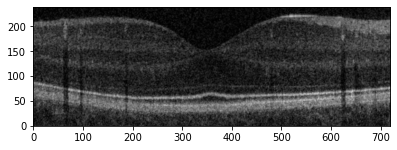

In [532]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [533]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.bezier import BezierSegment
from matplotlib.path import Path

class CamoWorm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour

        # Control points for the Bezier curve
        p0 = (self.x, self.y)
        p1 = (self.x + self.dr * np.cos(self.theta + self.dgamma), 
              self.y + self.dr * np.sin(self.theta + self.dgamma))
        p2 = (self.x + self.r * np.cos(self.theta), 
              self.y + self.r * np.sin(self.theta))

        self.bezier = BezierSegment(np.array([p0, p1, p2]))

    def generate_bezier_points(self, num_points=100):
        t_values = np.linspace(0, 1, num_points)
        points = [self.bezier.point_at_t(t) for t in t_values]
        x_points, y_points = zip(*points)
        return np.array(x_points, dtype=int), np.array(y_points, dtype=int)
    
    def control_points (self):
        return self.bezier.control_points
    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')

    def calculate_cost(self, image, other_worms):
        target_colour = image[int(self.y), int(self.x)] / 255.0
        x_points, y_points = self.generate_bezier_points()
        # Ensure points are within image boundaries
        x_points = np.clip(x_points, 0, image.shape[1]-1)
        y_points = np.clip(y_points, 0, image.shape[0]-1)
        worm_pixels = image[y_points, x_points]
        environment_cost = np.mean(np.abs(worm_pixels - target_colour))
        
        # Group knowledge cost
        position_cost = 0
        for other_worm in other_worms:
            if other_worm != self:
                distance = np.sqrt((self.x - other_worm.x)**2 + (self.y - other_worm.y)**2)
                position_cost += distance

        # Internal knowledge cost
        
        size_cost = self.r
        
        p0 = (self.x, self.y)
        p1 = (self.x + self.dr * np.cos(self.theta + self.dgamma), 
              self.y + self.dr * np.sin(self.theta + self.dgamma))
        p2 = (self.x + self.r * np.cos(self.theta), 
              self.y + self.r * np.sin(self.theta))
        self.bezier = BezierSegment(np.array([p0, p1, p2]))
        vector1 = np.array(p1) - np.array(p0)
        vector2 = np.array(p2) - np.array(p1)
        angle = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))
        self.curvature = angle
        curvature_cost = self.curvature
        
        color_cost = np.mean(np.abs(self.colour - target_colour))



        total_cost = size_cost + curvature_cost + color_cost + position_cost + environment_cost
        return total_cost
    
    def grow(self):
        self.r += 2  # Increase the radius
    def move(self, image_shape):
        self.x = np.random.randint(0, image_shape[1])  # Random x-coordinate
        self.y = np.random.randint(0, image_shape[0])  # Random y-coordinate
        
    def adapt_color(self, image):
        # Get the color of the pixel at the worm's position
        color = image[int(self.y), int(self.x)]
        color = color / 255
        # Set the worm's color to the color of the pixel
        self.colour = color
    def adapt_curvature(self):
        # Adjust the curvature based on some strategy
        self.dgamma += np.random.uniform(-1, 1)

        # Recalculate the control points for the Bezier curve
        p0 = (self.x, self.y)
        p1 = (self.x + self.dr * np.cos(self.theta + self.dgamma), 
              self.y + self.dr * np.sin(self.theta + self.dgamma))
        p2 = (self.x + self.r * np.cos(self.theta), 
              self.y + self.r * np.sin(self.theta))

        self.bezier = BezierSegment(np.array([p0, p1, p2]))


In [534]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [535]:
class Population:
    def __init__(self, size, image_shape):
        self.worms = [self.create_random_worm(image_shape) for _ in range(size)]
        self.image_shape = image_shape

    def create_random_worm(self, image_shape):
        x = np.random.randint(0, image_shape[1])
        y = np.random.randint(0, image_shape[0])
        r = np.random.randint(10, 100)
        theta = np.random.rand() * 2 * np.pi
        deviation_r = np.random.randint(-50, 50)
        deviation_gamma = np.random.rand() * 2 * np.pi
        width = np.random.randint(1, 10)
        colour = np.random.rand()
        return CamoWorm(x, y, r, theta, deviation_r, deviation_gamma, width, colour)

    def evaluate_fitness(self, image, other_worms):
        for worm in self.worms:
            worm.fitness = 1 / (1 + worm.calculate_cost(image, other_worms))

    def select(self):
        self.worms.sort(key=lambda x: x.fitness, reverse=True)
        self.worms = self.worms[:len(self.worms)//2]  # Keep top 50%
        self.worms = self.worms * 2

    def crossover(self):
        new_generation = []
        while len(new_generation) < len(self.worms) * 2:
            if len(self.worms) >= 2:
                parent1, parent2 = np.random.choice(self.worms, 2, replace=False)
                child1, child2 = self.mate(parent1, parent2)
                new_generation.extend([child1, child2])
            else:
                break
        self.worms = new_generation[:len(self.worms)]

    def mate(self, parent1, parent2):
        # Simple averaging crossover
        child1 = CamoWorm(
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        child2 = CamoWorm(
            (parent1.x + parent2.x) // 2,
            (parent1.y + parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        return child1, child2
    

Generation 1: 40 worms


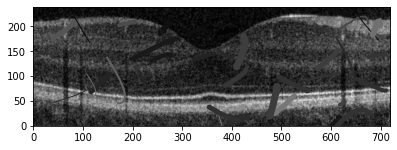

 Cost = 8850.441513427584
Generation 2: 40 worms


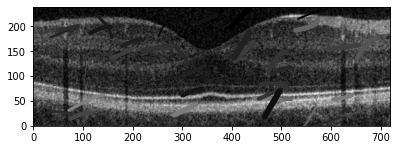

 Cost = 8055.64938605626
Generation 3: 40 worms


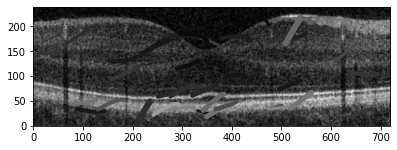

 Cost = 10655.472513270775
Generation 4: 40 worms


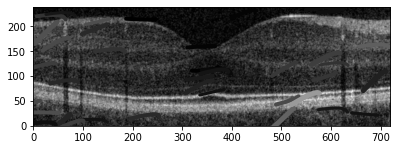

 Cost = 13518.052758300559
Generation 5: 40 worms


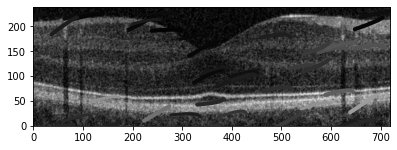

 Cost = 8291.446470172754
Generation 6: 40 worms


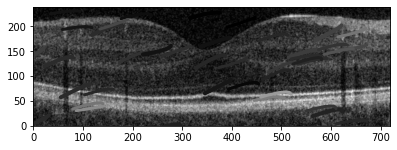

 Cost = 13261.506055407412
Generation 7: 40 worms


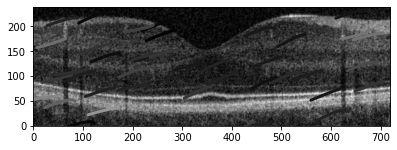

 Cost = 12820.867718291085
Generation 8: 40 worms


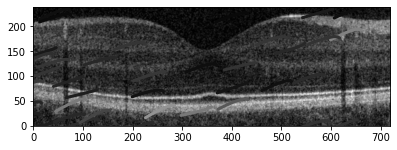

 Cost = 9343.056545975456
Generation 9: 40 worms


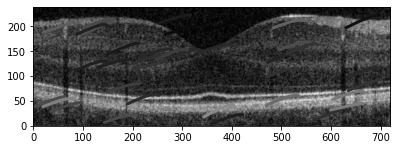

 Cost = 10980.759293012869
Generation 10: 40 worms


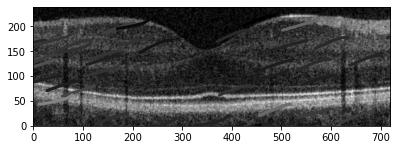

 Cost = 12444.554298342571
Generation 11: 40 worms


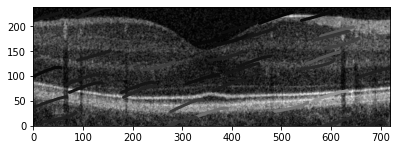

 Cost = 12305.731117026904
Generation 12: 40 worms


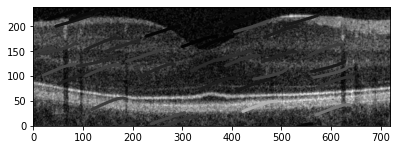

 Cost = 11609.769317387889
Generation 13: 40 worms


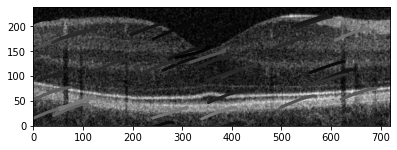

 Cost = 9528.281632719832
Generation 14: 40 worms


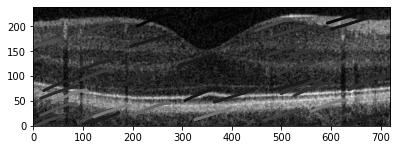

 Cost = 9464.455811917518
Generation 15: 40 worms


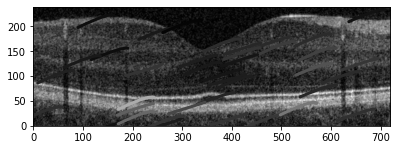

 Cost = 7057.819737236343
Generation 16: 40 worms


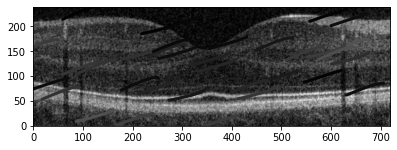

 Cost = 12966.171387412043
Generation 17: 40 worms


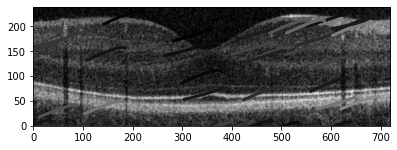

 Cost = 9924.102079898785
Generation 18: 40 worms


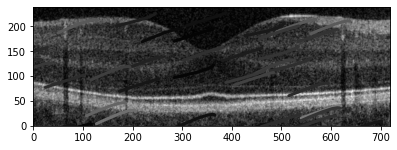

 Cost = 11199.987689722202
Generation 19: 40 worms


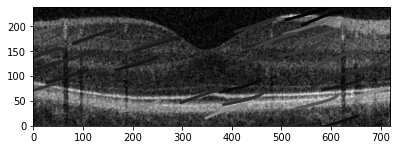

 Cost = 8847.737249809556
Generation 20: 40 worms


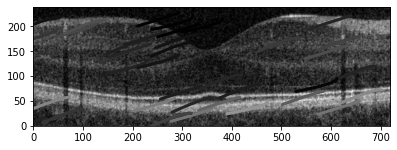

 Cost = 8253.727600412745
Generation 21: 40 worms


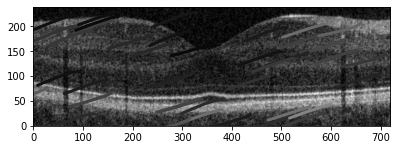

 Cost = 8562.111125269015
Generation 22: 40 worms


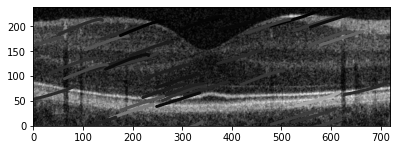

 Cost = 12009.810106829016
Generation 23: 40 worms


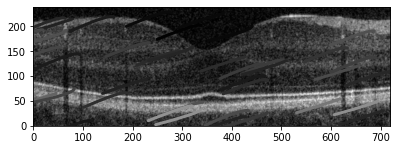

 Cost = 12425.554618640896
Generation 24: 40 worms


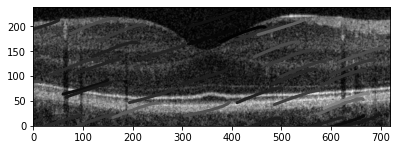

 Cost = 10486.964386706866
Generation 25: 40 worms


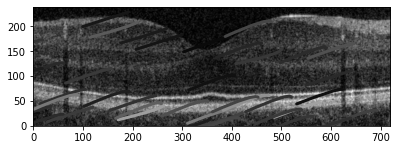

 Cost = 8651.078832784555
Generation 26: 40 worms


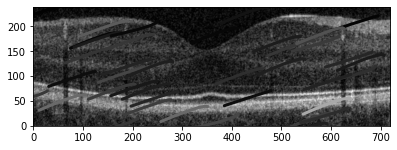

 Cost = 11810.566807080504
Generation 27: 40 worms


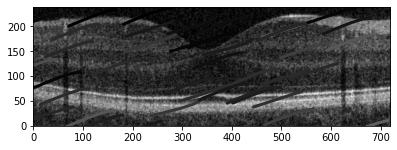

 Cost = 8123.973809639963
Generation 28: 40 worms


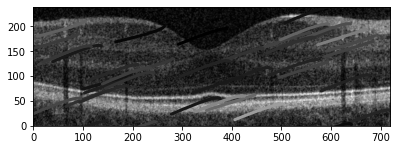

 Cost = 9568.11185904482
Generation 29: 40 worms


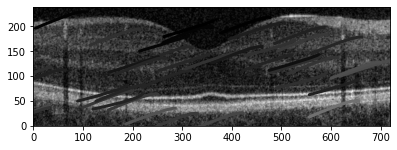

 Cost = 8329.04397332763
Generation 30: 40 worms


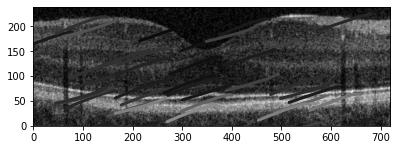

 Cost = 10697.860788817079
Generation 31: 40 worms


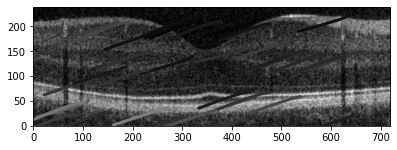

 Cost = 10231.405661828772
Generation 32: 40 worms


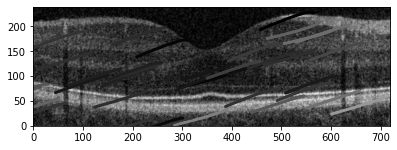

 Cost = 12420.25685564638
Generation 33: 40 worms


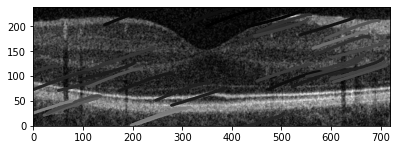

 Cost = 13504.951805947285
Generation 34: 40 worms


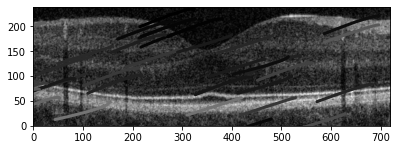

 Cost = 8699.795010216107
Generation 35: 40 worms


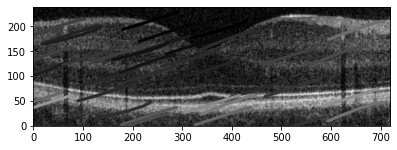

 Cost = 14658.905447489387
Generation 36: 40 worms


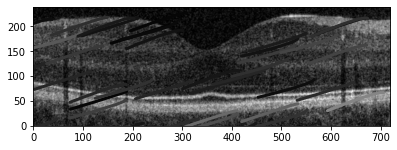

 Cost = 9526.820841259627
Generation 37: 40 worms


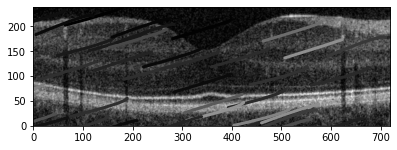

 Cost = 11982.521088936892
Generation 38: 40 worms


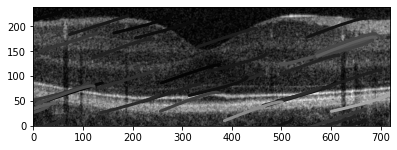

 Cost = 12205.74813393057
Generation 39: 40 worms


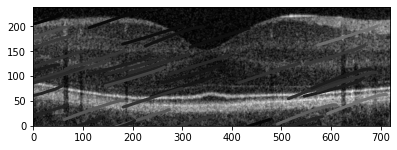

 Cost = 8626.292711453372
Generation 40: 40 worms


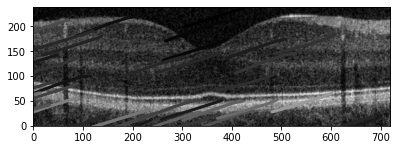

 Cost = 9384.838780143069


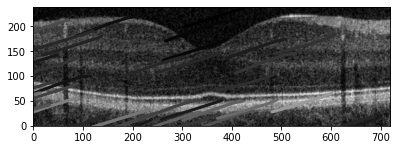

In [536]:

def run_genetic_algorithm(image, generations=40):
    population = Population(40, image.shape)
    for i in range(generations):
        population.evaluate_fitness(image,population.worms)
        population.select()
        population.crossover()
        for worm in population.worms:
            worm.grow()
            worm.move(image.shape)
            worm.adapt_color(image)
            worm.adapt_curvature()
        print(f"Generation {i+1}: {len(population.worms)} worms")
        visualize_population(population.worms, image)
        cost = worm.calculate_cost(image, population.worms)
        print(f" Cost = {cost}")
    return population


def visualize_population(worms, image):
    drawing = Drawing(image)
    drawing.add_worms(worms)  
    drawing.show()
# Example usage
optimized_population = run_genetic_algorithm(image)
drawing = Drawing(image)
drawing.add_worms(optimized_population.worms)
drawing.show()



&copy; Cara MacNish, UWA, 2024